## Blind source separation with an autoencoder

#### Author
<pre style="font-size: 120%">
Daniel Correa Tucunduva 
</pre>


## Setup

In [16]:
# Module setup

print(__doc__)

import tensorflow as tf
import numpy as np

from scipy import signal

import keras
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
from keras.layers import LSTM, Activation, Flatten, Dropout, BatchNormalization, Input, Dense, concatenate, Conv2D, Conv3D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from sklearn.decomposition import FastICA
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


the matrix 'mixed' is the sum of all 3 sources, where each source is a 2d gaussian
smoothed time series (sin, boxcar, sawtooth). the goal is to recover the original
time series, as well as the spatial topography of the original sources  



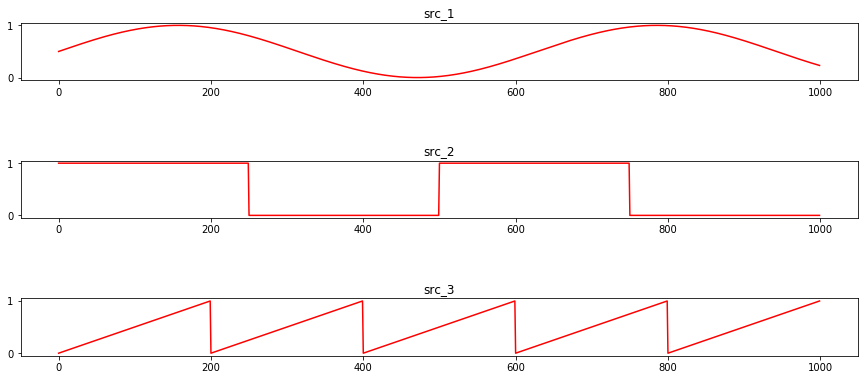

In [17]:
grid = np.zeros([10, 10])

src_loc_1 = [3, 3]
src_loc_2 = [5, 7]
src_loc_3 = [8, 2]

src_1 = np.sin(np.arange(0, 1000, 0.01))  # sin

src_2 = np.zeros(src_1.shape[0])  # box
for i in np.arange(0, src_2.shape[0], 500):
    src_2[i:i + 250] = 1

src_3 = np.zeros(src_1.shape[0])  # sawtooth
for i in np.arange(0, src_3.shape[0], 200):
    src_3[i:i + 200] = np.arange(0, 200) / 200

from scipy.ndimage import gaussian_filter

src_1 = np.reshape(src_1, [100000, 1])
src_2 = np.reshape(src_2, [100000, 1])
src_3 = np.reshape(src_3, [100000, 1])

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(src_1)
src_1 = scaler.transform(src_1)

scaler = scaler.fit(src_2)
src_2 = scaler.transform(src_2)

scaler = scaler.fit(src_3)
src_3 = scaler.transform(src_3)

track_1 = np.reshape(src_1, [100000, 1])
track_2 = np.reshape(src_2, [100000, 1])
track_3 = np.reshape(src_3, [100000, 1])

plt.figure(figsize=(15, 15))

models = [track_1[0:1000], track_2[0:1000], track_3[0:1000]]
names = ['src_1', 'src_2', 'src_3']
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(12, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.show()

In [18]:
def smooth_src(input_signal, sigma):
    print('smoothing...')
    for i in np.arange(0, input_signal.shape[2]):
        input_signal[:, :, i] = gaussian_filter(input_signal[:, :, i], sigma)

    return input_signal

src_grid_1 = np.zeros([10, 10, src_1.shape[0]])  # init 3d grid
src_grid_1[src_loc_1[0], src_loc_1[1], :] = src_1[:,0]  # place point source in grid
src_grid_1 = smooth_src(src_grid_1, 3)  # smooth

src_grid_2 = np.zeros([10, 10, src_2.shape[0]])
src_grid_2[src_loc_2[0], src_loc_2[1], :] = src_2[:,0]
src_grid_2 = smooth_src(src_grid_2, 3)

src_grid_3 = np.zeros([10, 10, src_3.shape[0]])
src_grid_3[src_loc_3[0], src_loc_3[1], :] = src_3[:,0]
src_grid_3 = smooth_src(src_grid_3, 3)

mixed = src_grid_1 + src_grid_2 + src_grid_3  # goal is to unmix mixed
"""
the matrix 'mixed' is the sum of all 3 sources, where each source is a 2d gaussian
smoothed time series (sin, boxcar, sawtooth). the goal is to recover the original
time series, as well as the spatial topography of the original sources  
"""

from sklearn.decomposition import FastICA

reshape_mixed = np.reshape(mixed, [100, mixed.shape[2]])
ica = FastICA(n_components=3)  # we'll be generous and assume there's 3
ica.fit(reshape_mixed.T)  # .T because 100000 instances, 100 attributes
ica_comps = ica.transform(reshape_mixed.T)  # get the components
ica_weights = np.reshape(ica.components_.T, [10, 10, 3])  # visualize these as images

smoothing...
smoothing...
smoothing...


In [19]:
def learning_rate_schedule(epoch):
    if epoch > 5:
        return 0.00025
    if epoch > 10:
        return 0.0005
    return 0.001

In [20]:
dense = Sequential()
dense.add(Dense(3, activation='linear', input_shape=[100], kernel_initializer='random_uniform', use_bias=False, kernel_constraint='nonneg'))
dense.add(Dense(100, activation='linear', kernel_initializer='random_uniform', use_bias=False, kernel_constraint='nonneg'))

dense.summary()

hidden_layer_output_model = Sequential()
hidden_layer_output_model.add(Dense(3, input_shape=[100], use_bias=False, kernel_constraint='nonneg'))

hidden_layer_output_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 300       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3)                 300       
Total params: 300
Trainable params: 300
Non-trainable params: 0
_________________________________________________________________


In [21]:
ae_input = reshape_mixed.T

dense_optimizer = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
dense.compile(loss='logcosh', optimizer=dense_optimizer)

dense_history = dense.fit(ae_input,
                          ae_input,    
                          batch_size=1000,
                          epochs=30,    
                          verbose=1,
                          callbacks=[LearningRateScheduler(learning_rate_schedule)])

Epoch 1/30
100000/100000 [==============================] - 1s 9us/step - loss: 3.7765e-05
Epoch 2/30
100000/100000 [==============================] - 1s 7us/step - loss: 1.0901e-05
Epoch 3/30
100000/100000 [==============================] - 1s 7us/step - loss: 5.2036e-06
Epoch 4/30
100000/100000 [==============================] - 1s 7us/step - loss: 4.0975e-06
Epoch 5/30
100000/100000 [==============================] - 1s 7us/step - loss: 1.9707e-06
Epoch 6/30
100000/100000 [==============================] - 1s 7us/step - loss: 5.8204e-07
Epoch 7/30
100000/100000 [==============================] - 1s 7us/step - loss: 3.3832e-07
Epoch 8/30
100000/100000 [==============================] - 1s 7us/step - loss: 2.9316e-07
Epoch 9/30
100000/100000 [==============================] - 1s 8us/step - loss: 2.6206e-07
Epoch 10/30
100000/100000 [==============================] - 1s 7us/step - loss: 2.3762e-07
Epoch 11/30
100000/100000 [==============================] - 1s 7us/step - loss: 2.1773e-

In [22]:
print(dense_history.history['loss'][-1])

hidden_layer_output_model.set_weights(dense.get_weights())

prediction = dense.predict(reshape_mixed.T)

8.972383696459475e-08


In [23]:
print(ae_input.shape)
print(prediction.shape)


(100000, 100)
(100000, 100)


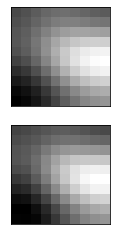

In [24]:
ax = plt.subplot(2, 1, 1)
plt.imshow(np.reshape(ae_input[0], [10, 10]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(2, 1, 2)
plt.imshow(np.reshape(prediction[0], [10, 10]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [25]:
hidden_layer_output = hidden_layer_output_model.predict(ae_input)

mixed_track_1 = np.reshape(hidden_layer_output.T[0], [100000, 1])
mixed_track_2 = np.reshape(hidden_layer_output.T[1], [100000, 1])
mixed_track_3 = np.reshape(hidden_layer_output.T[2], [100000, 1])

scaler = scaler.fit(mixed_track_1)
mixed_track_1 = scaler.transform(mixed_track_1)

scaler = scaler.fit(mixed_track_2)
mixed_track_2 = scaler.transform(mixed_track_2)

scaler = scaler.fit(mixed_track_3)
mixed_track_3 = scaler.transform(mixed_track_3)

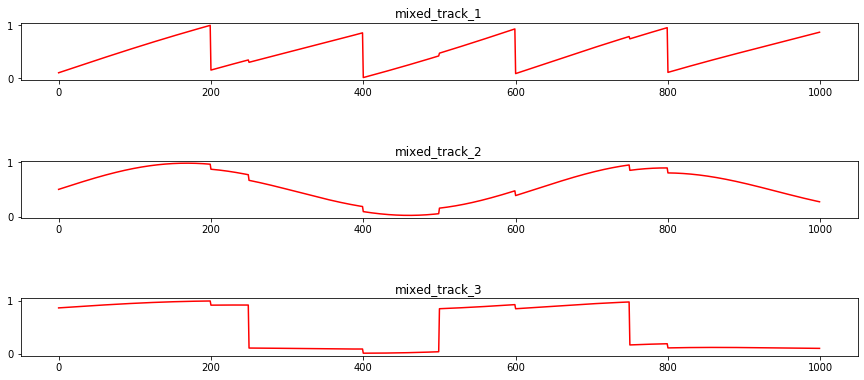

In [26]:
plt.figure(figsize=(15, 15))

models = [mixed_track_1[0:1000], mixed_track_2[0:1000], mixed_track_3[0:1000]]
names = ['mixed_track_1', 'mixed_track_2', 'mixed_track_3']
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(12, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.show()

In [27]:
clean_1 = np.copy(mixed_track_1)
clean_2 = np.copy(mixed_track_2)
clean_3 = np.copy(mixed_track_3)

clean_tracks = [clean_1, clean_2, clean_3]

In [98]:
keras.backend.clear_session()

umixer = Sequential()
umixer.add(Dense(3, input_shape=[3], kernel_initializer='random_uniform', use_bias=False, kernel_constraint='nonneg'))

umixer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [104]:
def custom_loss(y_true, y_pred):

    def _logcosh(x):
        return x + K.softplus(-2. * x) - K.log(2.)

    def entropy(y_true, y_pred):
        return K.mean(_logcosh(y_pred - y_true), axis=-1)
    
    def negentropy(y_true, y_pred):
        entropy = K.mean(_logcosh(y_pred - y_true), axis=-1)
        clipped = K.clip(entropy, min_value=1.0, max_value=1000)
        return K.pow(clipped, -1) - 1.0 + 1e-8

    splits_true = tf.split(y_true, 3, axis=1)
    splits_pred = tf.split(y_pred, 3, axis=1)

    cross_entropy_true = tf.concat([
        splits_true[0], splits_true[0], splits_true[0], splits_true[1], splits_true[1], splits_true[1], splits_true[2], splits_true[2], splits_true[2]
    ], axis=1)

    cross_entropy_pred = tf.concat([
        splits_pred[0], splits_pred[1], splits_pred[2], splits_pred[0], splits_pred[1], splits_pred[2], splits_pred[0], splits_pred[1], splits_pred[2] 
    ], axis=1)

    cross_entropy = entropy(y_true, y_pred)
    
    negentropy_true = tf.concat([
        splits_pred[0], splits_pred[0], splits_pred[1], splits_pred[1], splits_pred[2], splits_pred[2]
    ], axis=1)
    
    negentropy_pred = tf.concat([
        splits_pred[1], splits_pred[2], splits_pred[0], splits_pred[2], splits_pred[0], splits_pred[1]
    ], axis=1)
    
    negentropy = negentropy(negentropy_true, negentropy_pred)

    return negentropy

In [105]:
umixer_optimizer = keras.optimizers.rmsprop(learning_rate=0.00001)
umixer.compile(loss=custom_loss, optimizer=umixer_optimizer)

mixed_concat = np.concatenate([mixed_track_1, mixed_track_2, mixed_track_3], axis=1)

umixer_history = umixer.fit(mixed_concat,
                            mixed_concat,
                            batch_size=100000,
                            epochs=100,
                            verbose=0)

print('Loss: ', umixer_history.history['loss'][-1])
print(umixer.get_weights())

Loss:  9.999936878557492e-09
[array([[0.0012322 , 0.00636716, 0.00699656],
       [0.04426868, 0.0012326 , 0.00123142],
       [0.03253236, 0.0118451 , 0.00123226]], dtype=float32)]


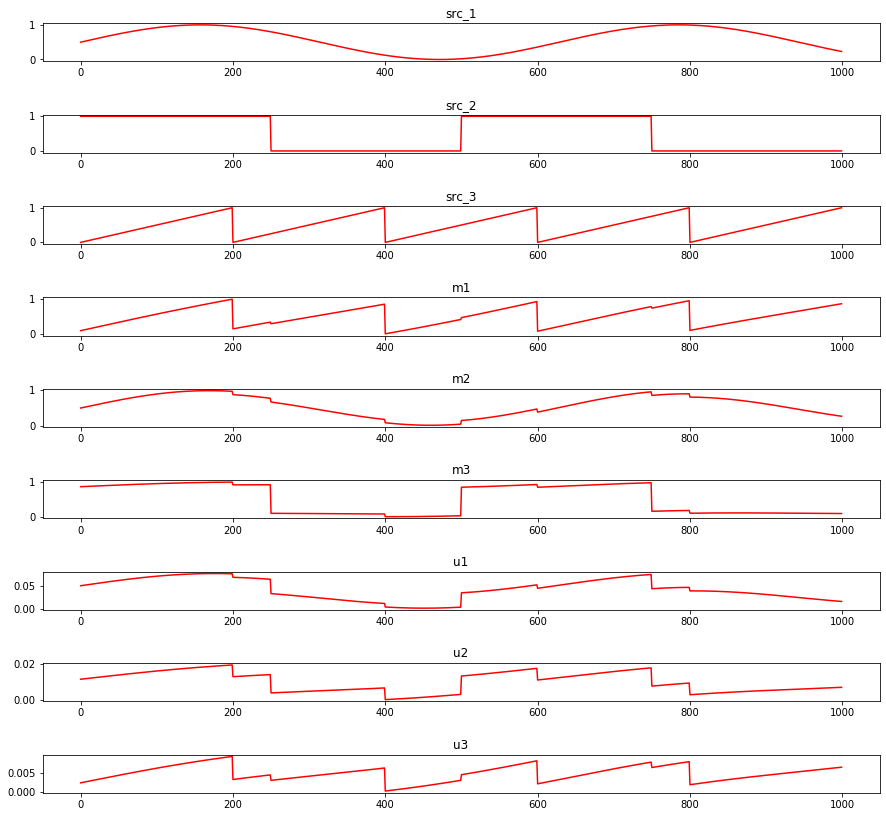

In [106]:
single_mix = umixer.predict(mixed_concat)

unmixed_1 = np.reshape(single_mix.T[0], [100000, 1])
unmixed_2 = np.reshape(single_mix.T[1], [100000, 1])
unmixed_3 = np.reshape(single_mix.T[2], [100000, 1])

plt.figure(figsize=(15, 15))

models = [track_1[0:1000], track_2[0:1000], track_3[0:1000], mixed_track_1[0:1000], mixed_track_2[0:1000], mixed_track_3[0:1000], unmixed_1[0:1000], unmixed_2[0:1000], unmixed_3[0:1000]]
names = ['src_1', 'src_2', 'src_3', 'm1', 'm2', 'm3', 'u1', 'u2', 'u3']
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(18, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.show()

In [32]:
# def svd_whiten(X):
# 
#     U, s, Vt = np.linalg.svd(X, full_matrices=False)
# 
#     # U and Vt are the singular matrices, and s contains the singular values.
#     # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
#     # will be white
#     X_white = np.dot(U, Vt)
# 
#     return X_white
# 
# def sym_decorrelation(W):
#     """ Symmetric decorrelation
#     i.e. W <- (W * W.T) ^{-1/2} * W
#     """
#     s, u = np.linalg.eigh(np.dot(W, W.T))
#     # u (resp. s) contains the eigenvectors (resp. square roots of
#     # the eigenvalues) of W * W.T
#     return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)
# 
# clean_concat = np.concatenate([clean_1, clean_2, clean_3], axis=1)
# white = sym_decorrelation(clean_concat.T)
# 
# for i in range(10000):
#     white = sym_decorrelation(white)
# white = white.T

In [33]:
# keras.backend.clear_session()
# 
# unmix = Sequential()
# unmix.add(Dense(1, input_shape=[3]))
# unmix.add(Dense(3, activation='linear'))
# 
# delta_optimizer = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
# 
# delta.summary()
# 
# delta.compile(loss='mean_squared_error', optimizer=delta_optimizer)
# 
# delta_input = np.concatenate([clean_1, clean_2, clean_3], axis=1)
# 
# delta_history = delta.fit(delta_input,
#                           delta_input,
#                           batch_size=1000,
#                           epochs=10,
#                           verbose=0)

In [34]:
# plt.figure(figsize=(15, 15))
# 
# models = [track_1[0:1000], track_2[0:1000], track_3[0:1000], mixed_track_1[0:1000], mixed_track_2[0:1000], mixed_track_3[0:1000], unmixed_1[0:1000]]
# names = ['src_1', 'src_2', 'src_3', 'm1', 'm2', 'm3', 'u1']
# colors = ['red', 'steelblue', 'orange']
# 
# for index, (model, name) in enumerate(zip(models, names), 1):
#     plt.subplot(18, 1, index * 2)
#     plt.title(name)
#     for sig, color in zip(model.T, colors):
#         plt.plot(sig, color=color)
# 
# plt.show()
